In [1]:
#!pip uninstall --user pandas
#!pip install --user pandas==1.5.3
import pandas as pd

print(pd.__version__)


print("over")

1.5.3
over


In [2]:
import pandas as pd
import torch
from d2l import torch as d2l
from torch import nn

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [5]:
#删除ID
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [6]:
all_features.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


In [7]:
all_features.shape

(2919, 79)

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

#标准化数据时将每个数据点的偏差（差值）除以标准差的主要目的是将数据转化为标准正态分布（均值为0，标准差为1）
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x - x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [9]:
#处理离散值，用独热编码替换
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [33]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
print(in_features)
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features,256),
        nn.ReLU(),
        #nn.Linear(256,128),
        #nn.ReLU(),
        nn.Linear(256,1))
    return net

331


In [34]:
#真实值减去预测值，然后除以真实值，得到相对误差
def log_rmse(net,features,labels):
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [35]:
def train(net,train_features, train_labels,test_features,test_labels,
          num_epochs, learning_rate, weight_decay, batch_size) :
    '''
    net：神经网络模型。
    train_features：训练集的特征。
    train_labels：训练集的标签。
    test_features：测试集的特征。
    test_labels：测试集的标签。
    num_epochs：训练的轮数（迭代次数）。
    learning_rate：学习率，用于控制模型参数的更新步长。
    weight_decay：权重衰减，用于控制正则化项的强度。
    batch_size：每个小批量的样本数。
    '''
    train_ls, test_ls =[],[]
    train_iter = d2l.load_array((train_features,train_labels), batch_size)
    optimizer = torch.optim.Adam (net.parameters(), lr=learning_rate,
                                  weight_decay=weight_decay)
    for epoch in range (num_epochs):
        for x, y in train_iter :
            optimizer.zero_grad()
            l = loss(net(x),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls


In [36]:
#K折交叉验证获取数据
def get_k_fold_data ( k, i,x, y) :
    assert k > 1
    fold_size = x.shape[0]// k
    x_train, y_train = None, None
    for j in range (k) :
        idx = slice( j * fold_size, (j + 1) * fold_size)
        x_part, y_part = x[idx,:],y[idx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat([x_train,x_part], 0)
            y_train = torch.cat([y_train,y_part], 0)
    return x_train, y_train, x_valid, y_valid

In [37]:
#K折交叉验证
def k_fold(k,x_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range (k):
        data = get_k_fold_data(k, i, x_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net,*data, num_epochs,
                                   learning_rate,weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1,num_epochs + 1)),[train_ls,valid_ls],
                        xlabel= 'epoch' , ylabel= 'rmse',xlim=[1,num_epochs],
                        legend=['train','valid'],yscale='log')
        print(f'fold{i + 1}, train log rmse {float(train_ls[-1]):f},'
              f'valid log rmse {float(valid_ls[-1]):f} ')
    return train_l_sum / k, valid_l_sum / k

fold1, train log rmse 0.063572,valid log rmse 0.130526 
fold2, train log rmse 0.073720,valid log rmse 0.149331 
fold3, train log rmse 0.076295,valid log rmse 0.146522 
fold4, train log rmse 0.073208,valid log rmse 0.136312 
fold5, train log rmse 0.077182,valid log rmse 0.162439 
5-折验证：平均训练log rmse：0.072795,平均验证log rmse：0.145026


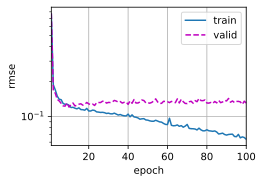

In [63]:
k,num_epochs,lr,weight_decay,batch_size = 5,100,0.05,0.05,64
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'
      f'平均验证log rmse：{float(valid_l):f}')

# 完整训练，提交结果

In [64]:
import numpy as np

train log rmse 0.056703


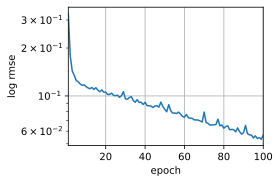

In [65]:
net = get_net()
train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
print(f'train log rmse {float(train_ls[-1]):f}')
preds = net(test_features).detach().numpy()
test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
submission.to_csv('submission.csv',index=False)
